In [272]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.15.0


In [273]:
import numpy as np

In [274]:
import scipy.signal as signal
import scipy.io.wavfile as wav

# this function resamples audio from a original sample rate to a target sample rate
def resample_audio(wav, orig_sr, target_sr):
    resampled_wav = signal.resample(wav, int(len(wav) * target_sr / orig_sr))
    return resampled_wav

In [275]:
# returns a TensorFlow Tensor which contains the audio waveform after it
#has been resampled to a mono signal with a sampling rate of 16000 Hz
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav_np = tf.numpy_function(np.squeeze, [wav], tf.float32)
    # Resample to 16000Hz
    resampled_wav = tf.numpy_function(resample_audio, [wav_np, sample_rate, 16000], tf.float32)
    # Convert back to TensorFlow tensor
    resampled_wav = tf.convert_to_tensor(resampled_wav)
    return resampled_wav

In [ ]:
path = 'C:/Users/maziy/Documents/smart_water/data/' #change path to be wherever you saved the data

files = []
for f in os.listdir(path):
    files.append(f)

files #check if files are correctly loaded

#Chop up the audio files to 3-sec-long segments. Make a folder called "chopped" and then within that, create folders with the names matching the audio file names. (for "10.wav", the corresponding folder name should be "10"). The folders within chopped should all be initially empty. If you're inputting new data then make sure to clear the folders first and adjust the folder names to correct names. 

In [279]:
!pip install pydub


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: C:\Users\maziy\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [280]:
from pydub import AudioSegment

In [281]:
# Directory where the chopped audio segments will be saved, change to "YOUR-DIRECTORY/chopped/""
chopped_dir = 'C:/Users/maziy/Documents/smart_water/chopped/'

def split_and_save_audio(input_audio_file, category, num_segments):
    audio = AudioSegment.from_wav(input_audio_file)

    for i in range(num_segments):
        t1 = i * 3000  # Start time in milliseconds
        t2 = (i + 1) * 3000  # End time in milliseconds
        segment = audio[t1:t2]

        output_file = os.path.join(chopped_dir+category, f'{category}_{i}chopped.wav')
        segment.export(output_file, format="wav")

# Split and save positive and negative audio segments
num_segments = 100 #change to (length of audio in seconds)/3
for i in files:
    split_and_save_audio(path+i, i.split('.')[0], num_segments) #add file to corresponding folders


In [282]:
#train neural network model
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    chopped_dir,
    batch_size=5,
    validation_split=0.2, #80% of data for training, 20% for testing
    seed=0,
    output_sequence_length=44100,
    subset='both'
)

Found 400 files belonging to 4 classes.
Using 320 files for training.
Using 80 files for validation.


In [283]:
label_names = np.array(train_ds.class_names)
label_names

array(['10', '15', '20', '5'], dtype='<U2')

In [284]:
train_ds.element_spec

(TensorSpec(shape=(None, 44100, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [285]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

"""This code below maps the squeeze function to each element of the train_ds and val_ds datasets using the map function. The tf.data.AUTOTUNE argument allows TensorFlow to dynamically adjust the number of parallel calls based on available CPU resources."""
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)


This cell below takes one example from the training dataset (train_ds) after applying the squeeze function and prints the shape of the audio and labels tensors.

In [286]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)


(5, 44100)
(5,)


The validation dataset (val_ds) is parted into two parts using the shard method. test_ds and val_ds represent different parts of the original validation dataset.

In [287]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)


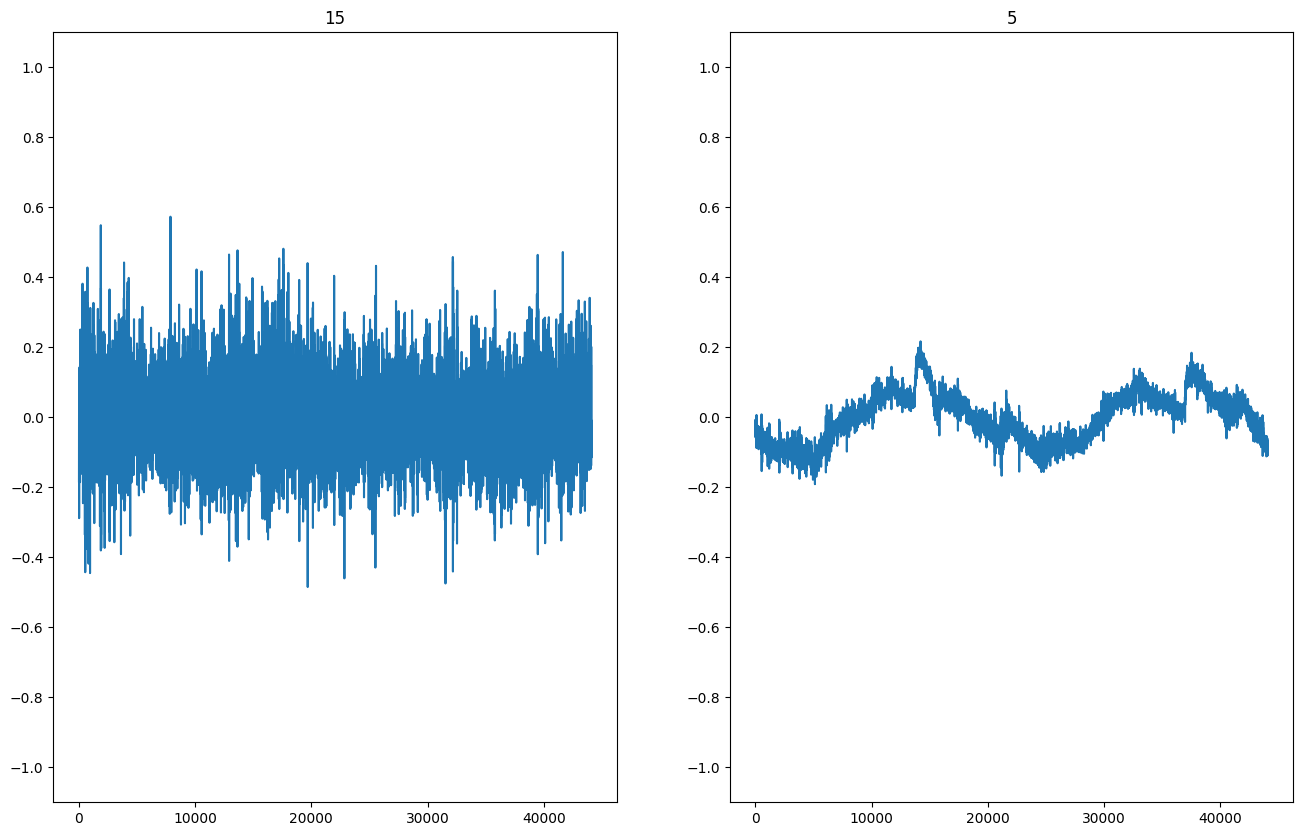

In [288]:
"""This code plots audio signals of the first two examples in the modified training dataset"""
plt.figure(figsize=(16, 10))
rows = 1
cols = 2
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])


#Neural Network

In [289]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [290]:
for i in range(1):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')


Label: 15
Waveform shape: (44100,)
Spectrogram shape: (343, 129, 1)
Audio playback


In [291]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


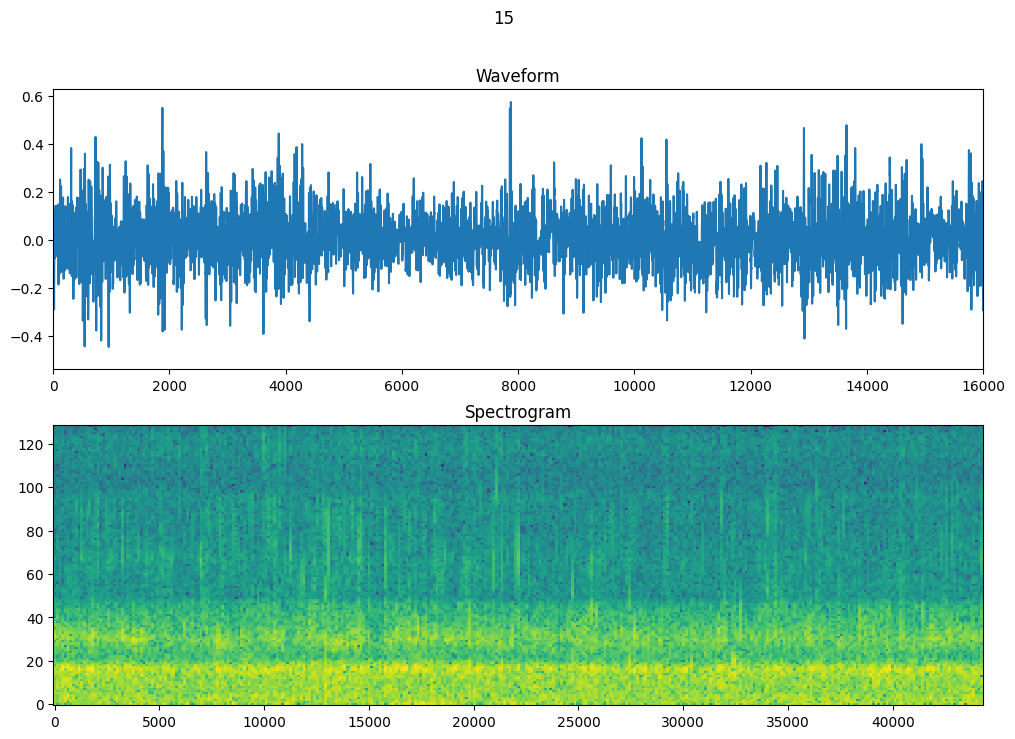

In [292]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()


In [293]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break


In [294]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)


In [300]:
from keras import layers,models
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()


Input shape: (343, 129, 1)
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_30 (Resizing)      (None, 32, 32, 1)         0         
                                                                 
 normalization_30 (Normaliz  (None, 32, 32, 1)         3         
 ation)                                                          
                                                                 
 conv2d_59 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_60 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_63 (Dropout)     

In [301]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [302]:
EPOCHS = 6
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,    
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)


Epoch 1/6
64/64 [==============================] - 2s 15ms/step - loss: 0.8759 - accuracy: 0.5719 - val_loss: 0.3608 - val_accuracy: 0.9250
Epoch 2/6
64/64 [==============================] - 1s 10ms/step - loss: 0.3564 - accuracy: 0.8781 - val_loss: 0.1731 - val_accuracy: 0.9750
Epoch 3/6
64/64 [==============================] - 1s 10ms/step - loss: 0.2344 - accuracy: 0.9187 - val_loss: 0.0617 - val_accuracy: 0.9750
Epoch 4/6
64/64 [==============================] - 1s 11ms/step - loss: 0.1871 - accuracy: 0.9312 - val_loss: 0.1131 - val_accuracy: 0.9750
Epoch 5/6
64/64 [==============================] - 1s 11ms/step - loss: 0.1722 - accuracy: 0.9312 - val_loss: 0.0912 - val_accuracy: 0.9750
Epoch 5: early stopping


Text(0, 0.5, 'Accuracy [%]')

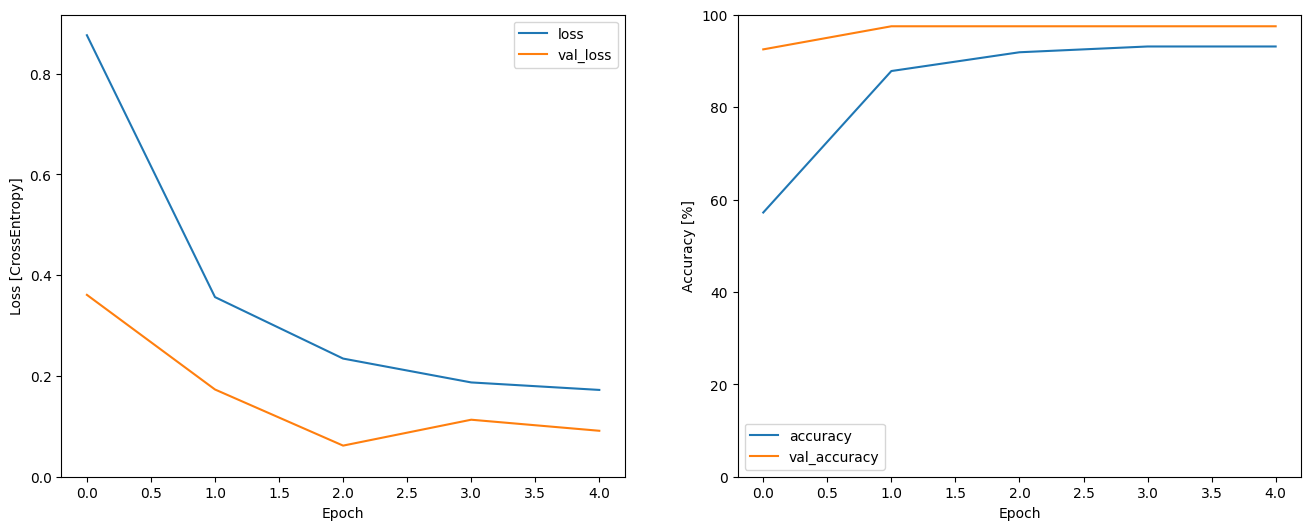

In [303]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')


In [304]:
model.evaluate(test_spectrogram_ds, return_dict=True)

8/8 [==============================] - 0s 2ms/step - loss: 0.1885 - accuracy: 0.9500


{'loss': 0.1884603500366211, 'accuracy': 0.949999988079071}